## Sentiment text classification using Bi-directional LSTM neural network
The task for this assignment would be to build a bi-directional LSTM neural network in order to recognize the sentiment of a tweet based on its text.

1.	Download the twitter airline sentiment dataset which contains tweets about different airlines and labels about the mood of the tweet (positive, neutral, negative). - https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment
2.	Prepare your data:
    *	Identify which columns you would need and use only them. This should be the text of the tweet and the target variable – the sentiment.
    *	Clean up the tweet text field from any non-word characters like mentions starting with @ and urls. Mentions will only introduce noise.
    *	Encode your target variable to numbers instead of words. Save the encoding somewhere for later use.
    *	Split your dataset into train and test using 90/10 proportion.
    *	Tokenize your sentences
        *	Create two lists of sentences based on the rows of your dataset – one for training, one for testing
        *	Instantiate a Keras tokenizer object. You need to specify an out-of-vocabulary token.
        *	Fit the tokenizer to the texts to create a vocabulary
        *	Use the tokenizer to covert the texts to number sequences based on vocabulary
        *	Pad the sequences specifying the max length of the sequences, the truncation type and the padding type. Use ‘post’ for both of those.
3.	Use Tensorflow to set up a bi-directional LSTM network.
    *	Hint 1: Check the bi-directional layer docs: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional
    *	Hint 2: if you stack LSTM layers on top of each other you need to have the return_sequences = True option set in all layers except the last one. This option makes sure that the LSTM layer returns not only the encoded final output, but the whole sequence.  If you deviate most probably you will get shape-related errors. If you have a Dense layer after and LSTM layer you need to set return_sequences to False.
    *	Hint 4: Since we will be doing multi-class classification with 3 label categories for the sentiment, we will need a softmax function at the end of the network. Check this tutorial for guidance: https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/
4.	Train the network on the training set and evaluate it on the test set.
5.	Construct a classification report with prediction and recall for each class in order to find out what the performance is for each class and overall. See this for details: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html


In [3]:
# Write your code in between these 
#==========

#==========
# This gives you a rough indicator in how many lines you can write out the expression.

In [25]:
# main imports
import os
import random
import pandas as pd
import numpy as np

# preprocessing and training
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# evaluation
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score

In [26]:
# helper functions
def set_seeds(seed: int):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

def loss_figure(history):
    fig1, ax1 = plt.subplots(figsize=(10, 6))
    ax1.plot()
    ax1.plot(history.history['loss'], label='train')
    ax1.plot(history.history['val_loss'], label='test')
    ax1.set_title('Loss')
    ax1.legend()
    return fig1, ax1

In [27]:
# setting seed
set_seeds(1234)

In [ ]:
# Download the dataset from: https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment

In [48]:
# import the data as df
#==========
df = pd.read_csv("Tweets.csv")
#==========
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [49]:
# clean strings in the text column
# Hint: pandas have a method for applying string operations on text columns
# remove mentions
#==========


df['clean_text']=df['text'].str.replace('(@\w+.*?)',"")
df.drop('text', inplace=True, axis=1)
df.head()

#==========
# remove urls
#==========
import re
df['clean_text'] = df['clean_text'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
df['clean_text'] = df['clean_text'].apply(lambda x: re.split('http:\/\/.*', str(x))[0])
#==========

C:\Users\vojislav\AppData\Local\Temp\ipykernel_12568\106259589.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df['clean_text']=df['text'].str.replace('(@\w+.*?)',"")


In [50]:
# encoding the target variable with neutral - 0, positive - 1 and negative - 2
# Hint: using a dictionary is a good way to create a mapping which you can save for later use
#==========
dictionary = {
    'positive' : 1,
    'negative' : 2,
    'neutral'  : 0 
}
# df['airline_sentiment'] = df['airline_sentiment'].astype('category')
# df['airline_sentiment_encoded'] = df['airline_sentiment'].cat.codes
df['airline_sentiment'].replace(dictionary, inplace=True)
df.head()

#==========

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,tweet_coord,tweet_created,tweet_location,user_timezone,clean_text
0,570306133677760513,0,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),What said.
1,570301130888122368,1,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),plus you've added commercials to the experien...
2,570301083672813571,0,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),I didn't today... Must mean I need to take an...
3,570301031407624196,2,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),"it's really aggressive to blast obnoxious ""en..."
4,570300817074462722,2,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),and it's a really big bad thing about it


The airline_sentiment sentiment should look something like this:
    
```
0         neutral
1        positive
2         neutral
3        negative
4        negative
```
We want to convert it to:
```
0        0
1        1
2        0
3        2
4        2
```

In [60]:
# dataset split 90/10
# Hint: use scikit learn methods for this
#==========
from sklearn.model_selection import train_test_split
X = df['clean_text']
y = df['airline_sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=420)
#==========

In [61]:
# convert training and testing input text to lowercase
#==========
X_train = X_train.str.lower()
X_test = X_test.str.lower()
#==========

In [62]:
# convert labels to dummies
# Hint: use pandas get_dummies method
#==========
y_train = pd.get_dummies(y_train, columns=['airline_sentiment'])
y_test = pd.get_dummies(y_test)
y_train.shape

#==========

(13176, 3)

We want the to convert the categorical label to dummy variables. In other words, from this:

```
13163    0
1378     2
4931     2
...
```

to this:

```
array([[1, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       ...,
```

If you used a 90/10 split of the data, the shape of your training labels should be:
```
(13176, 3)
```

In [ ]:
# After this step you should have 4 objects
# Two pandas containing the text for training and testing
# Two pandas containing the labels for training and testing

In [63]:
# Tokenization
# create two lists of sentences for training and testing based on
# the rows in the text column of the dataset
#==========

list_train = X_train.to_numpy()
list_test = X_test.to_numpy()

#==========

# instantiating the tokenizer
# Hint: Use the keras tokenizer object
#==========
tokenizer = Tokenizer(num_words= 10000)

#==========

# fitting the training sentences on the
# Hint: use the fit_on_texts method of the tokenizer
#==========
tokenizer.fit_on_texts(list_train)
#==========
vocab_size = len(tokenizer.word_index) + 1

# using the tokenizer to tokenize the sentences and pad them
# setting up the padding parameters
# max_lenght defines what is the maximum number of words in an input sentence
# it is used both for padding and for the input shape in the tensorflow model
max_length = 100
trunc_type = 'post'
padding_type = 'post'

# convert sentences to sequences of numbers
# Hint: use the texts_to_sequences method
#==========
sekvence_train = tokenizer.texts_to_sequences(list_train) 
sekvence_test = tokenizer.texts_to_sequences(list_test) 
#==========

# padding
# Hint: use the pad_sequences method
#==========
padding_train = pad_sequences(sekvence_train, maxlen = max_length, truncating=trunc_type, padding=padding_type)
padding_test  = pad_sequences(sekvence_test, maxlen = max_length, truncating=trunc_type, padding=padding_type)
#==========

# convert both labels objects to numpy arrays
#==========
# sekv_tr_arr = np.array(sekvence_train)
# sekv_ts_arr = np.array(sekvence_test)

pad_tr_arr = np.array(y_train)
pad_ts_arr = np.array(y_test)

#==========

Some clarifications are due here. 

Your tokenizer object creates a dictionary, where all the words in the training set are assigned a number. It is accessed via tokenizer.word_index and it looks like this:

```
{'<OOV>': 1,
 'to': 2,
 'the': 3,
 'i': 4,
 'a': 5,
 'you': 6,
 'for': 7,
 'flight': 8,
 ...
 ```
 
Your training sentences should look like this. Essentially a list of strings:
 
 ```
 [' i need some help. my record locator is bringing up two different flights in your system. one op by aa &amp; one from us airways.',
 ' tried filling out the status match form and got hit with an error message. how can i tell if it went through? ',
 ...
 ]
 ```
 
Your training sequences would look like this. They use the vocabulary to encode each word to its respective number:
 ```
 [[4, 69, 198, 41, 11, 719, 1520, 12, 1369, 47, 183, 359, 56, 13, 17, 247, 66, 6072, 98, 180, 51, 66, 29, 55, 426],
 [273, 3485, 48, 3, 325, 1022, 651, 10, 84, 1847, 21, 36, 602, 493, 57, 30, 4, 264, 61, 15, 509, 189],
  ...
  ]
 ```
 
The last part of it is the padded sequences. Padding means adding blank words to the end of the sentences in order to get each sequence to have the same lenght equal to the max length.

```
array([[   4,   69,  198, ...,    0,    0,    0],
       [ 273, 3485,   48, ...,    0,    0,    0],
       [  42, 1521,    9, ...,    0,    0,    0],
       ...,
       ]
```
Thus, the shape your training padded sequences should be:
```
(13176, 100)
```

For the testing padded sequences this would be:
```
(1464, 100)
```

In [37]:
# After this step you should have 4 numpy arrays again
# Two arrays of padded number sequences containing the encoded text for training and testing
# Two arrays containing the labels for training and testing

In [64]:
# Model definition
# The code in this cell is set up to use tensorflow functional API, but
# one could use the sequential API too. The functional API gives more control
# and can be more precise. It is like driving clutch and automatic. 
# The sequential API is automatic, the functional is clutch.

# Input layer
# the max_lenght defined above should be used to define the shape of the input
#==========
input = keras.Input(shape=(max_length,))
#==========

# Word embedding layer
# Hint, the vocab_size, the embedding_dim and the max_length 
# are used to define the shape of the embedding layer
embedding_dim = 50
#==========
embedding_layer = keras.layers.Embedding(output_dim=embedding_dim, input_dim=vocab_size, input_length=max_length)
x = embedding_layer(input)
#==========
# Bidirectional LSTM Layer
# Hint: the bidirectional layer should wrap the normal LSTM layer
#==========
bidirectional_layer = keras.layers.Bidirectional(keras.layers.LSTM(128,))
x = bidirectional_layer(x)


#==========

# Dense layer
# Use a relu activation for better results, but feel free to experiment
#==========
dense_layer = keras.layers.Dense(64, activation='relu')
x = dense_layer(x)
#==========
# Final softmax layer
# Hint: the number of neurons here should reflect the number of classes we are trying to predict
#==========
output_layer = keras.layers.Dense(3, activation='sigmoid')
output = output_layer(x)
#==========

model = tf.keras.Model(input, output)
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding_6 (Embedding)     (None, 100, 50)           642300    
                                                                 
 bidirectional_6 (Bidirectio  (None, 256)              183296    
 nal)                                                            
                                                                 
 dense_12 (Dense)            (None, 64)                16448     
                                                                 
 dense_13 (Dense)            (None, 3)                 195       
                                                                 
Total params: 842,239
Trainable params: 842,239
Non-trainable params: 0
_____________________________________________________

After you create your model object you can get a summary overview of its parameters and layers using `model.summary()`

This should look something like that if you use a single LSTM layer with 128 units and an intermediate dense layer with 64 units:
``` 
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 50)           648500    
                                                                 
 bidirectional (Bidirectiona  (None, 256)              183296    
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
=================================================================
Total params: 848,439
Trainable params: 848,439
Non-trainable params: 0
_________________________________________________________________
```

Epoch 1/3
27/27 [==============================] - 22s 665ms/step - loss: 0.5852 - f1_score: 0.6351 - val_loss: 0.6078 - val_f1_score: 0.6570
Epoch 2/3
27/27 [==============================] - 17s 622ms/step - loss: 0.4608 - f1_score: 0.7413 - val_loss: 0.5689 - val_f1_score: 0.6903
Epoch 3/3
27/27 [==============================] - 17s 633ms/step - loss: 0.3619 - f1_score: 0.8129 - val_loss: 0.5430 - val_f1_score: 0.7462


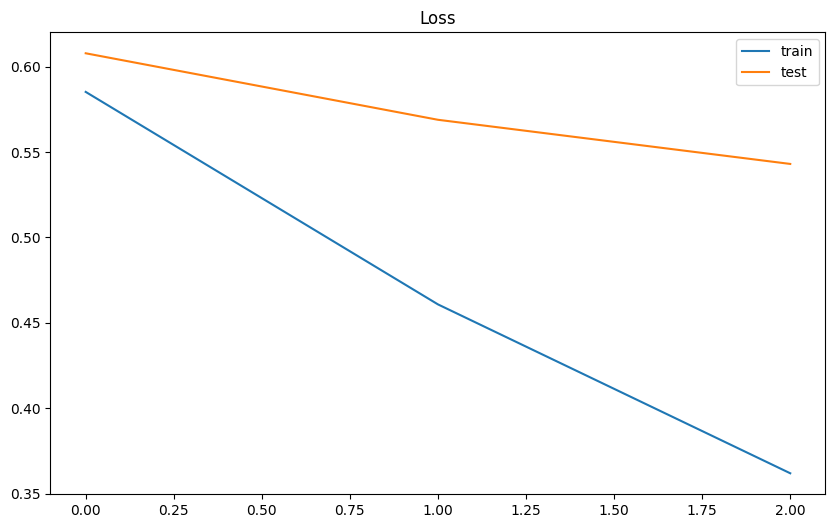

In [78]:
# model compilation and training
# we will train for 1 epoch to see if the model works
f1 = tfa.metrics.F1Score(3, 'macro')
batch_size = 500
num_epochs = 3

# compile the tf model
# We are using the categorical crossentropy loss function due to the number of classes we are
# trying to predict. We also use the Adam optimizer with 0.001 learning rate and we decide to 
# track the F1 during training.
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(0.001), metrics=[f1])

# run the training and extract the training history
# you need to input the training data, the batch_size, the number of epochs
# and the validation data as a tuple like (a, b)
#==========
history = model.fit(padding_train, 
                    pad_tr_arr, 
                    epochs=num_epochs,batch_size=batch_size, 
                    validation_data=(padding_test, pad_ts_arr),
)
#==========

# visualize the loss during training
fig1, _ = loss_figure(history)
# when you run the cell the model will start training
# if you train for two epochs it should take between 1-5 mins

In [79]:
# Evaluate the model by generating predictions and comparing them to the labels
# Hint: use the numpy argmax method to convert the predictions and the test labels
# along the last axis=-1
#==========

y_test_true = pad_ts_arr.argmax(axis=-1)
y_pred = model.predict(padding_test).argmax(axis=1)
y_pred_true = y_pred.argmax(axis=-1)

#==========

# Generate classification report
report = classification_report(y_pred=y_pred, y_true=y_test_true, output_dict=True)
pandas_report = pd.DataFrame(report).transpose()

46/46 [==============================] - 2s 30ms/step


In [81]:
# view the report and export to csv
pandas_report.to_csv("classification_report_.csv")
pandas_report

,precision,recall,f1-score,support
0,0.649701,0.647761,0.648729,335.000000
1,0.741784,0.683983,0.711712,231.000000
2,0.869138,0.887528,0.878237,898.000000
accuracy,0.800546,0.800546,0.800546,0.800546
macro avg,0.753541,0.739757,0.746226,1464.000000
weighted avg,0.798831,0.800546,0.799444,1464.000000
